## Module 9 Assignment 1: Natural Language Processing with Disaster Tweets
# Requirements

1. Conduct your analysis using a cross-validation design.
2. Conduct EDA.
3. Build at least three RNN models based on hyperparameter tuning.
4. Evaluate goodness of fit metrics.
5. Once you have your best-performing models, classify the test data and submit it to Kaggle. Provide your Kaggle.com user name and screen snapshots of your scores.
6. Discuss your model’s performance.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Libraries 

In [ ]:
import numpy as np
import pandas as pd
from pprint import pprint
import sklearn.model_selection
import gensim
import gensim.downloader

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')

import tensorflow as tf
print("You are using TensorFlow version", tf.__version__)
if len(tf.config.list_physical_devices('GPU')) > 0:
  print("You have a GPU enabled.")
else:
  print("Enable a GPU before running this notebook.")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential  # initial NN
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, InputLayer, BatchNormalization # construct each layer
from tensorflow.keras.layers import Conv2D # swipe across the image by 1
from tensorflow.keras.layers import MaxPool2D, GlobalMaxPool2D # swipe across by pool size
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau,LearningRateScheduler, TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy, mean_squared_error,sparse_categorical_crossentropy

import pandas as pd
import numpy as np
from random import shuffle
import os
import cv2
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline
from tqdm.notebook import trange,tqdm
from IPython.display import Image, display, Markdown, clear_output

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import svm, metrics
from sklearn.decomposition import PCA
from skimage import io

import sklearn.metrics as metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
You are using TensorFlow version 2.7.0
You have a GPU enabled.


In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/data_science/422_practical_machine_learning/module09/nlp-getting-started/train.csv")
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test = pd.read_csv("/content/drive/MyDrive/data_science/422_practical_machine_learning/module09/nlp-getting-started/test.csv")
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# from google.colab import files
# uploaded = files.upload()

# import io
# train = pd.read_csv(io.BytesIO(uploaded['train.csv']))
# train

In [ ]:
# from google.colab import files
# uploaded = files.upload()

# test = pd.read_csv(io.BytesIO(uploaded['test.csv']))
# test

# 2. EDA

In [ ]:
# find missing values
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [ ]:
# find missing values
test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

0    4342
1    3271
Name: target, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


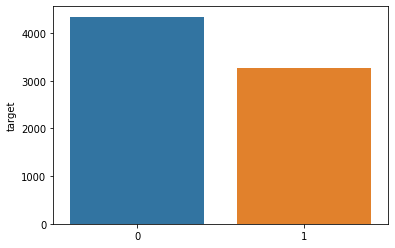

In [ ]:
# Distribution of target 
x=train['target'].value_counts()
print(x)
sns.barplot(x.index,x)

Non disaster tweets seems higher than disaster tweets. This might be expected if there is disaster happended

Mean of number of words in Disaster tweets: 15.167532864567411
Mean of number of words in Non-Disaster tweets: 14.704744357438969


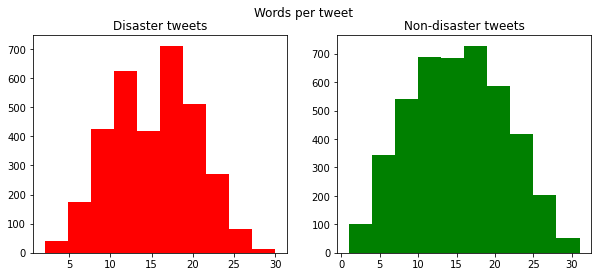

In [ ]:
# Count number of words in a tweet

train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
print("Mean of number of words in Disaster tweets:",train[train['target']==1]['word_count'].mean()) 
print("Mean of number of words in Non-Disaster tweets:",train[train['target']==0]['word_count'].mean()) 


# Plot total number of word-count per tweet

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words = train[train['target']==1]['word_count']
ax1.hist(train_words,color='Red')

ax1.set_title('Disaster tweets')
train_words=train[train['target']==0]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Words per tweet')
plt.show()

Above histogram depict distribution of words with number of tweets for  disaster and non-disaster tweets. They looks somewhat comparable

Mean of number of characters in Disaster tweets: 108.11342097217977
Mean of number of characters in Non-Disaster tweets: 95.70681713496084


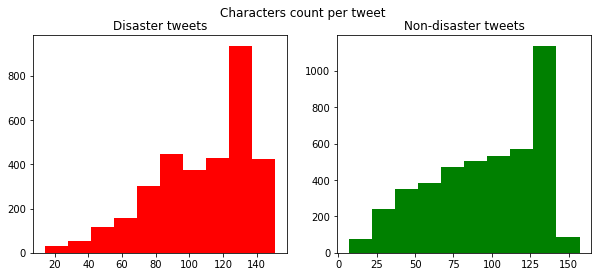

In [ ]:
# Count number of characters in a tweet

train['char_count'] = train['text'].apply(lambda x: len(str(x)))
print("Mean of number of characters in Disaster tweets:",train[train['target']==1]['char_count'].mean()) 
print("Mean of number of characters in Non-Disaster tweets:",train[train['target']==0]['char_count'].mean())  


# Plot total number of word-count per tweet

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
train_words = train[train['target']==1]['char_count']
ax1.hist(train_words,color='Red')

ax1.set_title('Disaster tweets')
train_words=train[train['target']==0]['char_count']
ax2.hist(train_words,color='green')
ax2.set_title('Non-disaster tweets')
fig.suptitle('Characters count per tweet')
plt.show()

Above histogram depict distribution of characters with number of tweets for  disaster and non-disaster tweets. They looks somewhat comparable

#3. Preprocessing

In [ ]:
##Importing Libraries for Neural Nets
import keras
from keras.models import Sequential, model_from_json
from keras.layers import Input, Dense, Dropout, Activation, LSTM, GRU, GlobalAvgPool1D, GlobalMaxPool1D
import math
from tqdm import tqdm
import pickle 
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from tqdm.keras import TqdmCallback

In [ ]:
# download glove twitter embeddings
pprint(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']


In [ ]:
# Takes about 5 minutes to execute, for 100-dim twitter vectors
# Takes about 10+ minutes to execute, for 200-dim twitter vectors
# glove_vectors_100 = gensim.downloader.load('glove-twitter-100')
glove_vectors_200 = gensim.downloader.load('glove-twitter-200')
glove = glove_vectors_200
embedding_length = 200


## https://nlp.stanford.edu/projects/glove/

[==================================================] 100.0% 758.5/758.5MB downloaded


In [ ]:
train.isnull().sum()
train.notnull().sum()

id            7613
keyword       7552
location      5080
text          7613
target        7613
word_count    7613
char_count    7613
dtype: int64

In [ ]:
print(train.shape)
print(test.shape)

# Convert Dataframe into array
text_train = np.array(train['text'])
text_test = np.array(test['text'])

# Merge both train and test dataset for pre-processing
text = np.concatenate((text_train, text_test), axis = 0)

(7613, 7)
(3263, 4)


In [ ]:
text

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ..., 'Green Line derailment in Chicago http://t.co/UtbXLcBIuY',
       'MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3',
       '#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm'],
      dtype=object)

In [ ]:
# word tokenization 
for i in range(len(text)):
    text[i] = word_tokenize(text[i])
print('After tokenization:')
print(text[0])

# filter out punctuation
for i in range(len(text)):
    text[i] = [word for word in text[i] if word.isalpha()]
print('After filtering out punctuation:')
print(text[0])

# make words lowercase 
for i in range(len(text)):
    text[i] = [word.lower() for word in text[i]]
print('After making lowercase:')
print(text[0])

# remove stopwords
for i in range(len(text)):
    text[i] = [word for word in text[i] if not word in stop_words]
print('After removing stopwords:')
print(text[0])

# concatenate list of words
for i in range(len(text)):
    text_concat = ''
    for word in text[i]:
        text_concat += word + ' '
    text[i] = text_concat
print('After concatenating words:')
text = np.array(text)

After tokenization:
['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', '#', 'earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'all']
After filtering out punctuation:
['Our', 'Deeds', 'are', 'the', 'Reason', 'of', 'this', 'earthquake', 'May', 'ALLAH', 'Forgive', 'us', 'all']
After making lowercase:
['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all']
After removing stopwords:
['deeds', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'us']
After concatenating words:


In [ ]:
glove = glove_vectors_200 

In [ ]:
# glove.most_similar('apple')

In [ ]:
print(glove.get_vector('twitter').shape)
glove.get_vector('twitter')

(200,)


array([ 1.0433e-01,  3.9882e-01, -6.9542e-01, -5.0984e-01,  6.6959e-02,
       -6.6277e-01,  2.5302e-01, -6.1320e-01,  6.6954e-02,  3.4897e-01,
       -3.4739e-01, -4.3558e-01,  3.0712e-01, -4.9802e-01, -9.2228e-01,
       -4.3034e-01,  8.4605e-02, -2.7696e-01,  3.6586e-01, -5.0237e-01,
        1.4885e-02,  2.1380e-01, -2.1657e-01, -6.2373e-02, -4.4156e-01,
       -1.6118e+00,  2.9537e-01, -1.0533e+00, -1.0280e+00,  9.4658e-01,
       -2.4770e-01,  1.2826e-01,  1.6348e-01, -4.6791e-01,  6.4240e-01,
       -1.6270e-01,  5.0066e-01, -1.4123e-01, -3.0530e-01, -2.2070e-01,
       -4.9756e-01,  4.8674e-01, -1.9606e-01,  4.7974e-01,  2.0614e-01,
       -6.0490e-02, -2.7333e-01, -2.8277e-01, -2.5695e-01,  1.5094e-01,
        5.7955e-01, -5.3770e-01,  1.7460e-02, -3.0005e-01, -8.4298e-02,
        3.6802e-01, -1.0117e+00,  2.3048e-01, -5.8210e-02, -2.3774e-01,
        6.5609e-03, -2.8949e-01, -2.7410e-01,  2.0116e-01, -1.4284e-01,
        2.1115e-01,  8.4995e-02,  3.3736e-01,  2.8317e-01,  3.37

In [ ]:
embeddings = []
for sentence in text:
    embedding = np.zeros(200)
    word_count = 0
    for word in sentence:
        if word in glove.vocab:
            embedding += glove.get_vector(word)
        word_count += 1
    if word_count != 0:
        embedding /= word_count
    embeddings.append(embedding)
embeddings = np.array(embeddings)

In [ ]:
embeddings

array([[ 0.25690012, -0.140232  ,  0.24398764, ..., -0.31653693,
         0.18508319,  0.06784627],
       [ 0.20790837, -0.16587368,  0.22354597, ..., -0.38288605,
         0.23654669,  0.1159744 ],
       [ 0.27879569, -0.17978917,  0.26413503, ..., -0.27719853,
         0.15926096,  0.09707358],
       ...,
       [ 0.2350036 , -0.21737831,  0.24629947, ..., -0.26244009,
         0.14810147,  0.10090137],
       [ 0.27011205, -0.12399437,  0.16931248, ..., -0.25445389,
         0.10958237,  0.01013755],
       [ 0.16244828, -0.11773796,  0.09622731, ..., -0.37400842,
         0.18820559,  0.0490994 ]])

In [ ]:
X_train = embeddings[:7613]
X_test = embeddings[7613:] 

y_train = train['target'].values

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(7613, 200)
(3263, 200)
(7613,)


In [ ]:
embeddings = []
for sentence in text:
    embedding = []
    for word in sentence.split():
        if word in glove.vocab:
            embedding.append(glove.get_vector(word).tolist())
        else:
            embedding.append(np.zeros(embedding_length).tolist())
    # pad extra zeros to make length of each sentence = 22 
    while len(embedding) < 22:
        embedding.append(np.zeros(embedding_length).tolist())
    embeddings.append(embedding)
embeddings = np.array(embeddings)
print(embeddings.shape)

(10876, 22, 200)


In [ ]:
embeddings

array([[[-0.31435001,  0.27825001, -0.12037   , ...,  0.17955001,
         -0.75700003, -1.29920006],
        [ 0.13054   ,  0.045089  , -0.058965  , ...,  0.68779999,
          0.25959   , -0.24171001],
        [-0.32275   ,  0.14165001,  0.053551  , ...,  0.064692  ,
          0.53280997,  0.41641   ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.48640001,  0.07589   ,  0.11724   , ..., -1.10109997,
         -1.00610006,  0.42403001],
        [-0.48187   , -0.29707   , -0.77723002, ..., -0.96424001,
          0.065379  ,  0.20376   ],
        [-0.43726   , -0.16597   ,  0.32686001, ..., -0.43044999,
          0.45885   ,  0.21791001],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [ ]:
X_train = embeddings[:7613]
X_test = embeddings[7613:]
y_train = train['target'].values

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(7613, 22, 200)
(3263, 22, 200)
(7613,)


In [ ]:
act = 'tanh'
batch_len = 32
opt = 'adam'
epoch = 100
val_split = 0.2

In [ ]:
keras.backend.clear_session()
model = Sequential()
model.add(Input(shape = (22, embedding_length)))
model.add(LSTM(22))
model.add(Dense(32, activation = act))
model.add(Dense(32, activation = act))
model.add(Dense(1, activation = 'sigmoid')) 
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs = epoch, batch_size = batch_len, verbose = 1, validation_split=val_split)

Epoch 1/100
191/191 [==============================] - 8s 14ms/step - loss: 0.5001 - accuracy: 0.7614 - val_loss: 0.4848 - val_accuracy: 0.7774
Epoch 2/100
191/191 [==============================] - 2s 10ms/step - loss: 0.4240 - accuracy: 0.8161 - val_loss: 0.4317 - val_accuracy: 0.8122
Epoch 3/100
191/191 [==============================] - 2s 10ms/step - loss: 0.3960 - accuracy: 0.8309 - val_loss: 0.4411 - val_accuracy: 0.8116
Epoch 4/100
191/191 [==============================] - 2s 10ms/step - loss: 0.3770 - accuracy: 0.8402 - val_loss: 0.4386 - val_accuracy: 0.8089
Epoch 5/100
191/191 [==============================] - 2s 9ms/step - loss: 0.3576 - accuracy: 0.8521 - val_loss: 0.4413 - val_accuracy: 0.8155
Epoch 6/100
191/191 [==============================] - 2s 10ms/step - loss: 0.3367 - accuracy: 0.8652 - val_loss: 0.4790 - val_accuracy: 0.8102
Epoch 7/100
191/191 [==============================] - 2s 9ms/step - loss: 0.3140 - accuracy: 0.8757 - val_loss: 0.4977 - val_accuracy: 0

In [ ]:
model.predict(X_test)

array([[0.9474875 ],
       [0.99838936],
       [0.5267128 ],
       ...,
       [0.999193  ],
       [0.9439921 ],
       [0.9985031 ]], dtype=float32)

In [ ]:
y_pred = model.predict(X_test)
y_train_pred = []
for i in range(len(test)):
    if y_pred[i] > 0.5:
        y_train_pred.append(1)
    else:
        y_train_pred.append(0)
test['target'] = y_train_pred
final = test[['id', 'target']]
final.to_csv('pred.csv', index = False)
final

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


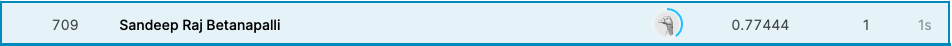

## Performing cross validation, hyperparameter tuning, goodness of fit metrics

In [ ]:
embeddings = []
for sentence in text:
    embedding = np.zeros(200)
    word_count = 0
    for word in sentence:
        if word in glove.vocab:
            embedding += glove.get_vector(word)
        word_count += 1
    if word_count != 0:
        embedding /= word_count
    embeddings.append(embedding)
embeddings = np.array(embeddings)

In [ ]:
embeddings

array([[ 0.25690012, -0.140232  ,  0.24398764, ..., -0.31653693,
         0.18508319,  0.06784627],
       [ 0.20790837, -0.16587368,  0.22354597, ..., -0.38288605,
         0.23654669,  0.1159744 ],
       [ 0.27879569, -0.17978917,  0.26413503, ..., -0.27719853,
         0.15926096,  0.09707358],
       ...,
       [ 0.2350036 , -0.21737831,  0.24629947, ..., -0.26244009,
         0.14810147,  0.10090137],
       [ 0.27011205, -0.12399437,  0.16931248, ..., -0.25445389,
         0.10958237,  0.01013755],
       [ 0.16244828, -0.11773796,  0.09622731, ..., -0.37400842,
         0.18820559,  0.0490994 ]])

In [ ]:
X_train = embeddings[:7613]
X_val = X_train[3807:]
X_train = X_train[:3807]
X_test = embeddings[7613:] 

y_train = train['target'].values
y_val = y_train[3807:]
y_train = y_train[:3807]
print("X_train.shape=",X_train.shape)
print("X_val.shape=",X_val.shape)
print("y_train.shape=",y_train.shape)
print("y_val.shape=",y_val.shape)
print("X_test.shape=",X_test.shape)

X_train.shape= (3807, 200)
X_val.shape= (3806, 200)
y_train.shape= (3807,)
y_val.shape= (3806,)
X_test.shape= (3263, 200)


In [ ]:
embeddings = []
for sentence in text:
    embedding = []
    for word in sentence.split():
        if word in glove.vocab:
            embedding.append(glove.get_vector(word).tolist())
        else:
            embedding.append(np.zeros(embedding_length).tolist())
    # pad extra zeros to make length of each sentence = 22 
    while len(embedding) < 22:
        embedding.append(np.zeros(embedding_length).tolist())
    embeddings.append(embedding)
embeddings = np.array(embeddings)
print(embeddings.shape)

(10876, 22, 200)


In [ ]:
embeddings

array([[[-0.31435001,  0.27825001, -0.12037   , ...,  0.17955001,
         -0.75700003, -1.29920006],
        [ 0.13054   ,  0.045089  , -0.058965  , ...,  0.68779999,
          0.25959   , -0.24171001],
        [-0.32275   ,  0.14165001,  0.053551  , ...,  0.064692  ,
          0.53280997,  0.41641   ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.48640001,  0.07589   ,  0.11724   , ..., -1.10109997,
         -1.00610006,  0.42403001],
        [-0.48187   , -0.29707   , -0.77723002, ..., -0.96424001,
          0.065379  ,  0.20376   ],
        [-0.43726   , -0.16597   ,  0.32686001, ..., -0.43044999,
          0.45885   ,  0.21791001],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  

In [ ]:
X_train = embeddings[:7613]
X_val = X_train[3807:]
X_train = X_train[:3807]
X_test = embeddings[7613:] 

y_train = train['target'].values
y_val = y_train[3807:]
y_train = y_train[:3807]
print("X_train.shape=",X_train.shape)
print("X_val.shape=",X_val.shape)
print("y_train.shape=",y_train.shape)
print("y_val.shape=",y_val.shape)
print("X_test.shape=",X_test.shape)

X_train.shape= (3807, 22, 200)
X_val.shape= (3806, 22, 200)
y_train.shape= (3807,)
y_val.shape= (3806,)
X_test.shape= (3263, 22, 200)


In [ ]:
#Model 1
act = 'tanh'
batch_len = 32
opt = 'adam'
epoch = 100
val_split = 0.2
keras.backend.clear_session()
model = Sequential()
model.add(Input(shape = (22, embedding_length)))
model.add(LSTM(22))
model.add(Dense(32, activation = act))
model.add(Dense(32, activation = act))
model.add(Dense(1, activation = 'sigmoid')) 
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, epochs = epoch, batch_size = batch_len, verbose = 1, validation_split=val_split)

Epoch 1/100
96/96 [==============================] - 4s 16ms/step - loss: 0.5338 - accuracy: 0.7356 - val_loss: 0.4639 - val_accuracy: 0.7992
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.4247 - accuracy: 0.8204 - val_loss: 0.4572 - val_accuracy: 0.8110
Epoch 3/100
96/96 [==============================] - 1s 9ms/step - loss: 0.3964 - accuracy: 0.8371 - val_loss: 0.4759 - val_accuracy: 0.7913
Epoch 4/100
96/96 [==============================] - 1s 10ms/step - loss: 0.3738 - accuracy: 0.8496 - val_loss: 0.4636 - val_accuracy: 0.7887
Epoch 5/100
96/96 [==============================] - 1s 10ms/step - loss: 0.3476 - accuracy: 0.8663 - val_loss: 0.4823 - val_accuracy: 0.7913
Epoch 6/100
96/96 [==============================] - 1s 10ms/step - loss: 0.3270 - accuracy: 0.8680 - val_loss: 0.5168 - val_accuracy: 0.7822
Epoch 7/100
96/96 [==============================] - 1s 10ms/step - loss: 0.3019 - accuracy: 0.8818 - val_loss: 0.5393 - val_accuracy: 0.7822
Epoch 8

In [ ]:
y_val_pred = model.predict(X_val)
y_val_pred_1 = []
for i in range(len(y_val_pred)):
    if y_val_pred[i] > 0.5:
        y_val_pred_1.append(1)
    else:
        y_val_pred_1.append(0)

In [ ]:
print(metrics.confusion_matrix(y_val, y_val_pred_1))         ## confusion_matrix
print(metrics.classification_report(y_val, y_val_pred_1))

[[1719  370]
 [ 568 1149]]
              precision    recall  f1-score   support

           0       0.75      0.82      0.79      2089
           1       0.76      0.67      0.71      1717

    accuracy                           0.75      3806
   macro avg       0.75      0.75      0.75      3806
weighted avg       0.75      0.75      0.75      3806



In [ ]:
#model 2
act = 'tanh'
batch_len = 32
opt = 'adam'
epoch = 100
val_split = 0.2
keras.backend.clear_session()
model = Sequential()
model.add(Input(shape = (22, embedding_length)))
model.add(LSTM(11))
model.add(Dense(32, activation = act))
model.add(Dense(32, activation = act))
model.add(Dense(1, activation = 'sigmoid')) 
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, epochs = epoch, batch_size = batch_len, verbose = 1, validation_split=val_split)

y_val_pred = model.predict(X_val)
y_val_pred_2 = []
for i in range(len(y_val_pred)):
    if y_val_pred[i] > 0.5:
        y_val_pred_2.append(1)
    else:
        y_val_pred_2.append(0)

print(metrics.confusion_matrix(y_val, y_val_pred_2))         ## confusion_matrix
print(metrics.classification_report(y_val, y_val_pred_2))

Epoch 1/100
96/96 [==============================] - 4s 15ms/step - loss: 0.5631 - accuracy: 0.7087 - val_loss: 0.4969 - val_accuracy: 0.7835
Epoch 2/100
96/96 [==============================] - 1s 9ms/step - loss: 0.4374 - accuracy: 0.8148 - val_loss: 0.4759 - val_accuracy: 0.7795
Epoch 3/100
96/96 [==============================] - 1s 9ms/step - loss: 0.4044 - accuracy: 0.8342 - val_loss: 0.4958 - val_accuracy: 0.7769
Epoch 4/100
96/96 [==============================] - 1s 9ms/step - loss: 0.3786 - accuracy: 0.8476 - val_loss: 0.5146 - val_accuracy: 0.7717
Epoch 5/100
96/96 [==============================] - 1s 9ms/step - loss: 0.3651 - accuracy: 0.8539 - val_loss: 0.4933 - val_accuracy: 0.7730
Epoch 6/100
96/96 [==============================] - 1s 9ms/step - loss: 0.3448 - accuracy: 0.8673 - val_loss: 0.5132 - val_accuracy: 0.7703
Epoch 7/100
96/96 [==============================] - 1s 9ms/step - loss: 0.3257 - accuracy: 0.8775 - val_loss: 0.5457 - val_accuracy: 0.7638
Epoch 8/100


In [ ]:
#model 3
act = 'tanh'
batch_len = 32
opt = 'adam'
epoch = 100
val_split = 0.2
keras.backend.clear_session()
model = Sequential()
model.add(Input(shape = (22, embedding_length)))
model.add(LSTM(22))
model.add(Dense(64, activation = act))
model.add(Dense(64, activation = act))
model.add(Dense(1, activation = 'sigmoid')) 
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, epochs = epoch, batch_size = batch_len, verbose = 1, validation_split=val_split)

y_val_pred = model.predict(X_val)
y_val_pred_3 = []
for i in range(len(y_val_pred)):
    if y_val_pred[i] > 0.5:
        y_val_pred_3.append(1)
    else:
        y_val_pred_3.append(0)

print(metrics.confusion_matrix(y_val, y_val_pred_3))         ## confusion_matrix
print(metrics.classification_report(y_val, y_val_pred_3))

Epoch 1/100
96/96 [==============================] - 4s 15ms/step - loss: 0.5288 - accuracy: 0.7369 - val_loss: 0.4900 - val_accuracy: 0.7808
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.4137 - accuracy: 0.8217 - val_loss: 0.4960 - val_accuracy: 0.7795
Epoch 3/100
96/96 [==============================] - 1s 10ms/step - loss: 0.3912 - accuracy: 0.8368 - val_loss: 0.4947 - val_accuracy: 0.7703
Epoch 4/100
96/96 [==============================] - 1s 9ms/step - loss: 0.3669 - accuracy: 0.8476 - val_loss: 0.5245 - val_accuracy: 0.7493
Epoch 5/100
96/96 [==============================] - 1s 9ms/step - loss: 0.3476 - accuracy: 0.8594 - val_loss: 0.5266 - val_accuracy: 0.7822
Epoch 6/100
96/96 [==============================] - 1s 10ms/step - loss: 0.3213 - accuracy: 0.8742 - val_loss: 0.5456 - val_accuracy: 0.7598
Epoch 7/100
96/96 [==============================] - 1s 10ms/step - loss: 0.2927 - accuracy: 0.8874 - val_loss: 0.5920 - val_accuracy: 0.7651
Epoch 8/

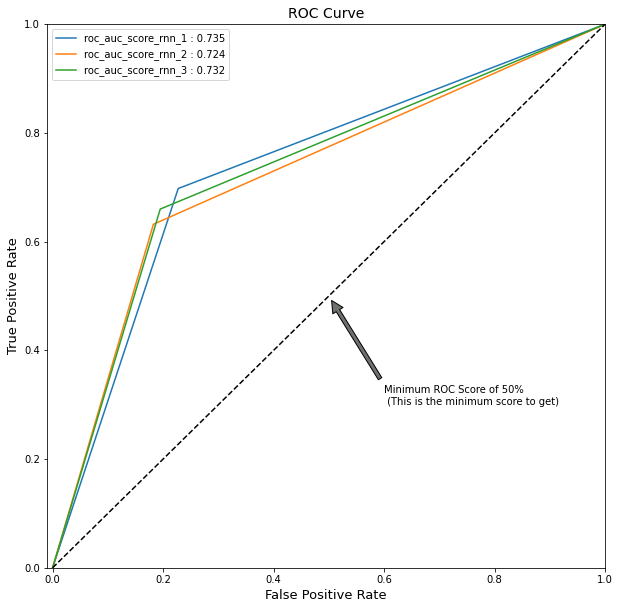

In [ ]:
#ROC curve
rnn_fpr_1, rnn_tpr_1, rnn_threshold_1 = roc_curve(y_val, y_val_pred_1)
roc_auc_score_rnn_1=roc_auc_score(y_val, y_val_pred_1)
rnn_fpr_2, rnn_tpr_2, rnn_threshold_2 = roc_curve(y_val, y_val_pred_2)
roc_auc_score_rnn_2=roc_auc_score(y_val, y_val_pred_2)
rnn_fpr_3, rnn_tpr_3, rnn_threshold_3 = roc_curve(y_val, y_val_pred_3)
roc_auc_score_rnn_3=roc_auc_score(y_val, y_val_pred_3)

def graph_roc_curve_multiple():
    plt.figure(figsize=(10,10))
    plt.title('ROC Curve', fontsize=14)
    plt.plot(rnn_fpr_1, rnn_tpr_1, label='roc_auc_score_rnn_1 : %.5s' % roc_auc_score_rnn_1)
    plt.plot(rnn_fpr_2, rnn_tpr_2, label='roc_auc_score_rnn_2 : %.5s' % roc_auc_score_rnn_2)
    plt.plot(rnn_fpr_3, rnn_tpr_3, label='roc_auc_score_rnn_3 : %.5s' % roc_auc_score_rnn_3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple()
plt.show()

#### After seeing ROC curve rnn_1 model has highest score 0.735. So doing cross validation with rnn_1 model. 

In [ ]:
# performing cross validation by swapping the train and validation data
print("X_train.shape=",X_train.shape)
print("X_val.shape=",X_val.shape)
print("y_train.shape=",y_train.shape)
print("y_val.shape=",y_val.shape)
print("X_test.shape=",X_test.shape)

temp=X_train.copy()
X_train=X_val.copy()
X_val=temp.copy()

temp=y_train.copy()
y_train=y_val.copy()
y_val=temp.copy()

print("\n")
print("X_train.shape=",X_train.shape)
print("X_val.shape=",X_val.shape)
print("y_train.shape=",y_train.shape)
print("y_val.shape=",y_val.shape)
print("X_test.shape=",X_test.shape)

X_train.shape= (3807, 22, 200)
X_val.shape= (3806, 22, 200)
y_train.shape= (3807,)
y_val.shape= (3806,)
X_test.shape= (3263, 22, 200)


X_train.shape= (3806, 22, 200)
X_val.shape= (3807, 22, 200)
y_train.shape= (3806,)
y_val.shape= (3807,)
X_test.shape= (3263, 22, 200)


Epoch 1/100
96/96 [==============================] - 4s 16ms/step - loss: 0.5214 - accuracy: 0.7520 - val_loss: 0.4275 - val_accuracy: 0.8150
Epoch 2/100
96/96 [==============================] - 1s 10ms/step - loss: 0.4240 - accuracy: 0.8233 - val_loss: 0.4108 - val_accuracy: 0.8215
Epoch 3/100
96/96 [==============================] - 1s 10ms/step - loss: 0.4001 - accuracy: 0.8321 - val_loss: 0.4059 - val_accuracy: 0.8241
Epoch 4/100
96/96 [==============================] - 1s 9ms/step - loss: 0.3765 - accuracy: 0.8489 - val_loss: 0.4095 - val_accuracy: 0.8228
Epoch 5/100
96/96 [==============================] - 1s 10ms/step - loss: 0.3577 - accuracy: 0.8591 - val_loss: 0.4175 - val_accuracy: 0.8202
Epoch 6/100
96/96 [==============================] - 1s 10ms/step - loss: 0.3393 - accuracy: 0.8719 - val_loss: 0.4222 - val_accuracy: 0.8255
Epoch 7/100
96/96 [==============================] - 1s 10ms/step - loss: 0.3206 - accuracy: 0.8758 - val_loss: 0.4249 - val_accuracy: 0.8307
Epoch 8

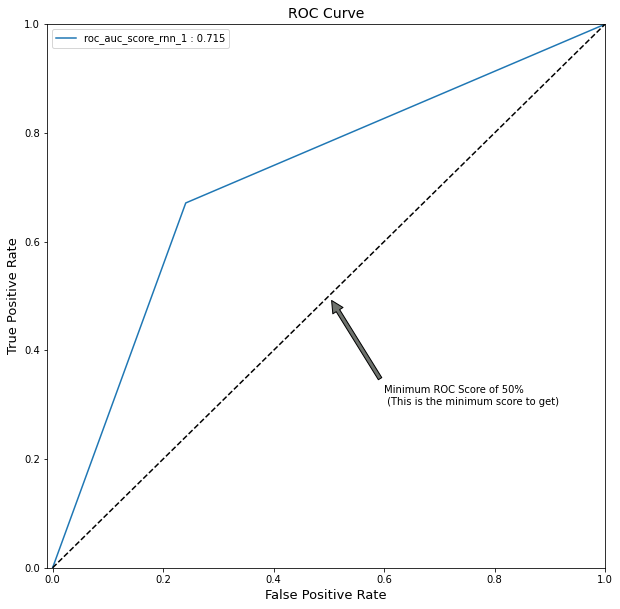

In [ ]:
act = 'tanh'
batch_len = 32
opt = 'adam'
epoch = 100
val_split = 0.2
keras.backend.clear_session()
model = Sequential()
model.add(Input(shape = (22, embedding_length)))
model.add(LSTM(22))
model.add(Dense(32, activation = act))
model.add(Dense(32, activation = act))
model.add(Dense(1, activation = 'sigmoid')) 
model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(X_train, y_train, epochs = epoch, batch_size = batch_len, verbose = 1, validation_split=val_split)

y_val_pred = model.predict(X_val)
y_val_pred_1 = []
for i in range(len(y_val_pred)):
    if y_val_pred[i] > 0.5:
        y_val_pred_1.append(1)
    else:
        y_val_pred_1.append(0)

print(metrics.confusion_matrix(y_val, y_val_pred_1))         ## confusion_matrix
print(metrics.classification_report(y_val, y_val_pred_1))
#ROC curve
rnn_fpr, rnn_tpr, rnn_threshold = roc_curve(y_val, y_val_pred_1)
roc_auc_score_rnn=roc_auc_score(y_val, y_val_pred_1)

def graph_roc_curve_multiple(rnn_fpr, rnn_tpr):
    plt.figure(figsize=(10,10))
    plt.title('ROC Curve', fontsize=14)
    plt.plot(rnn_fpr, rnn_tpr, label='roc_auc_score_rnn_2 : %.5s' % roc_auc_score_rnn)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(rnn_fpr, rnn_tpr)
plt.show()

In [ ]:
#Predicting final test data with better performing model rnn_1. 
y_pred = model.predict(X_test)
y_train_pred = []
for i in range(len(test)):
    if y_pred[i] > 0.5:
        y_train_pred.append(1)
    else:
        y_train_pred.append(0)
test['target'] = y_train_pred
final = test[['id', 'target']]
final.to_csv('pred1.csv', index = False)
final

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


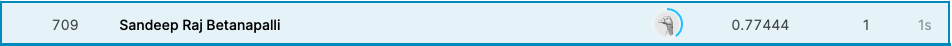

The model rnn1 with LSTM performed better than other models. The comparison can be seen in ROC curve and result can be seen in kaggle score. 

In [69]:
while True:pass

KeyboardInterrupt: ignored